In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '0'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.objectives import binary_crossentropy, mse
from keras.losses import mean_squared_error
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [3]:
def get_two_head_gen(input_shape, noise_shape, n_layers, thickness, encoding_dim, optimizer):
    input_main = Input(shape=(input_shape, ), name='input_main')
    input_noise = Input(shape=(noise_shape, ), name='input_noise')
    
    x = keras.layers.concatenate([input_noise, input_main])
    
    for i in range(n_layers - 1):
        x = Dense(thickness*2, activation='relu')(x)
        x = BatchNormalization()(x)
        x = keras.layers.concatenate([x, input_main])
        
    y_1 = Dense(thickness, activation='relu')(x)
    y_1 = BatchNormalization()(y_1)
    y_1 = keras.layers.concatenate([y_1, input_main])
    generated_1 = Dense(encoding_dim, name='generated_1')(y_1)
    
    
    y_2 = Dense(thickness, activation='relu')(x)
    y_2 = BatchNormalization()(y_2)
    y_2 = keras.layers.concatenate([y_2, input_main])
    generated_2 = Dense(encoding_dim, name='generated_2')(y_2)
    
    
    gen_1 = Model([input_noise, input_main], generated_1, name="gen_1")
    gen_2 = Model([input_noise, input_main], generated_2, name="gen_2")
    
#     optimizer_adam_1 = optimizers.Adam(lr=0.001)
    gen_1.compile(loss='binary_crossentropy', optimizer=optimizer)
    
#     optimizer_adam_2 = optimizers.Adam(lr=0.001)
    gen_2.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gen_1, gen_2

In [4]:
def get_discriminator(input_shape, alpha_shape, n_layers, thickness, optimizer):
    input_alpha = Input(shape=(alpha_shape, ), name='input_main')
    inputs = Input(shape=(input_shape, ), name='input')
    
    x = keras.layers.concatenate([inputs, input_alpha])
    
    for i in range(n_layers - 1):
        x = Dense(thickness*2, activation='relu')(x)
        x = BatchNormalization()(x)
        x = keras.layers.concatenate([x, input_alpha])
        
    out = Dense(1, name='out', activation='sigmoid')(x)
    
    disc = Model([inputs, input_alpha], out, name="disc")
    
#     optimizer_adam = optimizers.Adam(lr=0.001)
    disc.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return disc

In [5]:
def get_gan_network(generator, discriminator, input_shape, noise_shape, optimizer):
    discriminator.trainable = False
    
    gan_input_main = Input(shape=(input_shape,))
    gan_input_noise = Input(shape=(noise_shape,))
    x = generator([gan_input_noise, gan_input_main])
    gan_output = discriminator([x, gan_input_main] )
    
    gan = Model(inputs=[gan_input_noise, gan_input_main], outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [6]:
def generate_input(uniform_bounds, uniform_dim, normal_dim, batch_size):
    alpha = np.random.uniform(*uniform_bounds, size=uniform_dim)
    return alpha, np.array([np.random.normal(alpha, 1, size=normal_dim) for i in range(batch_size)])

def generate_data(bounds, batch_size, normal_dim=1000, num=10000):
    alphas = []
    datas = []

    for i in range(num):
        alpha, data = generate_input(bounds, 1, normal_dim, batch_size)
        alphas.append(alpha)
        datas.append(data)

    return alphas, datas

In [7]:
# alpha_01, data_01 = generate_data([3, 4], 256)
# np.save("alpha_01", alpha_01)
# np.save("data_01", data_01)

# alpha_02, data_02 = generate_data([0, 2], 256)
# np.save("alpha_02", alpha_02)
# np.save("data_02", data_02)

# alpha_12, data_12 = generate_data([1, 2], 256, num=1000)
# np.save("alpha_12", alpha_12)
# np.save("data_12", data_12)

In [8]:
alpha_01 = np.load("alpha_01.npy")[:5000]
data_01 = np.load("data_01.npy")[:5000]

alpha_02 = np.load("alpha_02.npy")[:5000]
data_02 = np.load("data_02.npy")[:5000]

alpha_12 = np.load("alpha_12.npy")[:5000]
data_12 = np.load("data_12.npy")[:5000]

In [9]:
alpha_01.shape

(5000, 1)

In [10]:
def prepare_data(alphas, datas, split=False, batch_size=64):
    real_batch_size = len(datas) / len(alphas)
    
    batch_alpha = []
    batch_data = []
    
    for i, alpha in enumerate(alphas):
        for j in range(datas.shape[1]//batch_size):
            batch_alpha.append([alpha]*batch_size)
            batch_data.append(datas[i][j*batch_size:(j+1)*batch_size])
            
    x = np.random.permutation(len(batch_alpha))
            
    if not split:
        return np.array(batch_alpha)[x], np.array(batch_data)[x]
    else:
        if 0 <= split <= 1:
            size = len(np.array(batch_alpha))
            return np.array(batch_alpha)[x][int(split*size):], np.array(batch_data)[x][int(split*size):], \
                   np.array(batch_alpha)[x][:int(split*size)], np.array(batch_data)[x][:int(split*size)]
        else:
            return np.array(batch_alpha)[x][split:], np.array(batch_data)[x][split:], \
                   np.array(batch_alpha)[x][:split], np.array(batch_data)[x][:split]


In [11]:
batch_alpha_01, batch_data_01, valid_alpha_01, valid_data_01 = prepare_data(alpha_01, data_01, split=1000)
batch_alpha_02, batch_data_02, valid_alpha_02, valid_data_02 = prepare_data(alpha_02, data_02, split=1000)
batch_alpha_12, batch_data_12 = prepare_data(alpha_12, data_12)

In [12]:
batch_alpha_02.shape, valid_alpha_02.shape

((19000, 64, 1), (1000, 64, 1))

In [13]:
batch_data_01.shape, valid_data_01.shape

((19000, 64, 1000), (1000, 64, 1000))

In [14]:
INPUT_SHAPE = 1
INPUT_NOISE = 1000
N_LAYERS = 3
THICKNESS = 512
ENCODING_DIM = 1000

EPOCHS = 10

In [15]:
import scipy
import scipy.stats
def compare_data_to_dist(x, mus, sd=1):
    ll = []
    for i, item in enumerate(x):
        ll_1 = 0
        for j in item:
            ll_1 += np.log(scipy.stats.norm(mus[i], sd).pdf(j))
        ll.append(ll_1)
    
    print ("The LL is: %.4f" % (np.mean(ll)))

In [18]:
opt = optimizers.Adam(lr=0.0001)

generator_1, generator_2 = get_two_head_gen(input_shape=INPUT_SHAPE, noise_shape=INPUT_NOISE, 
                             n_layers=N_LAYERS, thickness=THICKNESS, encoding_dim=ENCODING_DIM, optimizer=opt)
discriminator = get_discriminator(input_shape=ENCODING_DIM, alpha_shape=INPUT_SHAPE, n_layers=N_LAYERS, thickness=THICKNESS, optimizer=opt)
gan_1 = get_gan_network(generator_1, discriminator, input_shape=INPUT_SHAPE, noise_shape=INPUT_NOISE, optimizer=opt)
gan_2 = get_gan_network(generator_2, discriminator, input_shape=INPUT_SHAPE, noise_shape=INPUT_NOISE, optimizer=opt)

In [19]:
def train_generator(batch_alpha, batch_data):
    while True:
        rp = np.random.permutation(len(batch_alpha))
        for x, y in zip(batch_alpha[rp], batch_data[rp]):
            yield x, y

In [20]:
from time import time

generators = [generator_1, generator_2]
gans = [gan_1, gan_2]
uniform_bounds = [[0, 1], [0, 2]]

alphas_valid = [np.concatenate(np.squeeze(valid_alpha_01)[:100]), np.concatenate(np.squeeze(valid_alpha_02)[:100])]
batches_valid = [np.concatenate(valid_data_01[:100]), np.concatenate(valid_data_02[:100])]

alpha_valid = np.concatenate(batch_alpha_12[:100])
batch_valid = np.concatenate(batch_data_12[:100])

wds = {"01": [], "02": [], "12": []}
dls = {"01": [], "02": [], "12": []}

iters_disc = 1
iters_gen=5

def valid(num):
    noise = np.random.normal(0, 1, size=[len(alphas_valid[0]), INPUT_NOISE])
#     alpha, real = generate_input(uniform_bounds[num], INPUT_SHAPE, ENCODING_DIM, batch_size)

    generated = generators[num].predict([noise, alphas_valid[num]])
    wd = np.mean([scipy.stats.wasserstein_distance(r, g) for r, g in zip(batches_valid[num], generated)])
    print("WD", wd)
    wds["0"+str(num+1)].append(wd)
    
    to_desc = np.concatenate([batches_valid[num], generated])

    y_dis = np.zeros(2*len(alphas_valid[num]))
    y_dis[:len(alpha_valid)] = 1

    # Train discriminator
    discriminator.trainable = False
    dl = discriminator.evaluate([to_desc, np.concatenate([alphas_valid[num], alphas_valid[num]])], y_dis)
    print("DL", dl)
    dls["0"+str(num+1)].append(dl)
    
    if num == 0:
        print("*****VAL [1, 2]*****")
        
        generated = generators[num].predict([noise, alpha_valid])
        wd = np.mean([scipy.stats.wasserstein_distance(r, g) for r, g in zip(batch_valid, generated)])
        print("WD", wd)
        wds["12"].append(wd)

        to_desc = np.concatenate([batch_valid, generated])

        y_dis = np.zeros(2*len(alpha_valid))
        y_dis[:len(alpha_valid)] = 1

        # Train discriminator
        discriminator.trainable = False
        dl = discriminator.evaluate([to_desc, np.concatenate([alpha_valid, alpha_valid])], y_dis)
        print("DL", dl)
        dls["12"].append(dl)
        
        print("*****VAL [1, 2]*****")
        
def train_desc(num, batch_alpha, batch_data):
    batch_size = batch_alpha.shape[0]
    noise = np.random.normal(0, 1, size=[batch_size, INPUT_NOISE])

    generated = generators[num].predict([noise, batch_alpha])
    to_desc = np.concatenate([batch_data, generated])

    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 1

    discriminator.trainable = True
    generators[0].trainable = False
    generators[1].trainable = False
    discriminator.train_on_batch([to_desc, np.concatenate([batch_alpha, batch_alpha])], y_dis)
    
def train_gen(num, batch_alpha, batch_data):
    batch_size = batch_alpha.shape[0]
    noise = np.random.normal(0, 1, size=[batch_size, INPUT_NOISE])
    y_gen = np.ones(batch_size)
    generators[num].trainable = True
    discriminator.trainable = False
    gans[num].train_on_batch([noise, batch_alpha], y_gen)

def train(epochs=100, batch_size=64):
    # Get the training and testing data

    for epoch in range(1, epochs+1):
        train_gen_01 = train_generator(np.squeeze(batch_alpha_01), batch_data_01)
        train_gen_02 = train_generator(np.squeeze(batch_alpha_02), batch_data_02)
        
        for i in range(iters_disc):
            batch_alpha, batch_data = next(train_gen_01)
            train_desc(0, batch_alpha, batch_data)
            
        for i in range(iters_gen):
            batch_alpha, batch_data = next(train_gen_01)
            train_gen(0, batch_alpha, batch_data)
            
        for i in range(iters_disc):
            batch_alpha, batch_data = next(train_gen_02)
            train_desc(1, batch_alpha, batch_data)
            
        for i in range(iters_gen):
            batch_alpha, batch_data = next(train_gen_02)
            train_gen(1, batch_alpha, batch_data)
            
        if epoch % 10 == 0:
            print()
            print ('-'*15, 'Epoch %d' % epoch, '-'*15)
            valid(0)
            valid(1)
            print()

In [ ]:
train(10000, 64)


--------------- Epoch 10 ---------------
WD 0.4862878638925723
12800/12800 [==============================] - 1s 81us/step
DL 0.6197108859653919
*****VAL [1, 2]*****
WD 1.5564482759779366
12800/12800 [==============================] - 1s 70us/step
DL 0.00011485207516983564
*****VAL [1, 2]*****
WD 0.9537903814733503
12800/12800 [==============================] - 1s 65us/step
DL 0.3082428901938594


--------------- Epoch 20 ---------------
WD 0.48366336237444846
12800/12800 [==============================] - 1s 62us/step
DL 1.0295019218231807
*****VAL [1, 2]*****
WD 1.55376082219224
12800/12800 [==============================] - 1s 62us/step
DL 3.0459489059353473e-06
*****VAL [1, 2]*****
WD 0.9518647788150522
12800/12800 [==============================] - 1s 69us/step
DL 0.4984546814593361


--------------- Epoch 30 ---------------
WD 0.4828773968764494
12800/12800 [==============================] - 1s 65us/step
DL 1.271882554247202
*****VAL [1, 2]*****
WD 1.5528677851506705
12800/12800

12800/12800 [==============================] - 1s 70us/step
DL 3.9179431389868567e-07
*****VAL [1, 2]*****
WD 0.9187617257549691
12800/12800 [==============================] - 1s 63us/step
DL 0.9178812964783478


--------------- Epoch 220 ---------------
WD 0.45599293931976786
12800/12800 [==============================] - 1s 65us/step
DL 1.780466257532728
*****VAL [1, 2]*****
WD 1.5137475889530585
12800/12800 [==============================] - 1s 65us/step
DL 1.0866248068452932e-06
*****VAL [1, 2]*****
WD 0.9164300717846643
12800/12800 [==============================] - 1s 68us/step
DL 0.9625330388878386


--------------- Epoch 230 ---------------
WD 0.45452003246092887
12800/12800 [==============================] - 1s 65us/step
DL 1.6446999146985692
*****VAL [1, 2]*****
WD 1.5119988422139485
12800/12800 [==============================] - 1s 63us/step
DL 1.031484882219047e-06
*****VAL [1, 2]*****
WD 0.9148919133597683
12800/12800 [==============================] - 1s 67us/step
DL 0.87

12800/12800 [==============================] - 1s 65us/step
DL 0.5653242737031288


--------------- Epoch 420 ---------------
WD 0.4299185283535585
12800/12800 [==============================] - 1s 64us/step
DL 1.1595805282309226
*****VAL [1, 2]*****
WD 1.4758519307813458
12800/12800 [==============================] - 1s 65us/step
DL 1.4612392843105226e-06
*****VAL [1, 2]*****
WD 0.8850047303097983
12800/12800 [==============================] - 1s 66us/step
DL 0.5804265927569884


--------------- Epoch 430 ---------------
WD 0.4288018658425831
12800/12800 [==============================] - 1s 65us/step
DL 1.194044276378792
*****VAL [1, 2]*****
WD 1.4748555992475425
12800/12800 [==============================] - 1s 65us/step
DL 1.8348376060828286e-06
*****VAL [1, 2]*****
WD 0.882992194303349
12800/12800 [==============================] - 1s 68us/step
DL 0.6072408884626106


--------------- Epoch 440 ---------------
WD 0.42797056188540294
12800/12800 [==============================] - 1s

In [44]:
noise = np.random.normal(0, 1, size=[len(alphas_valid[0]), INPUT_NOISE])

generated = generators[0].predict([noise, np.array(alphas_valid[0])])

(array([  2.,   3.,  34., 105., 228., 302., 199.,  90.,  31.,   6.]),
 array([-3.41722456, -2.69952658, -1.9818286 , -1.26413062, -0.54643264,
         0.17126534,  0.88896332,  1.60666129,  2.32435927,  3.04205725,
         3.75975523]),
 <a list of 10 Patch objects>)

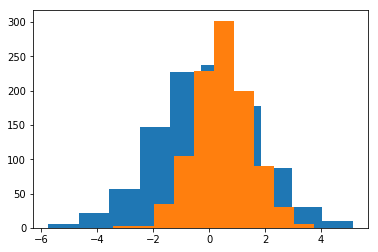

In [49]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.hist(generated[0])
plt.hist(batches_valid[0][0])